In [1]:
%pylab inline
import pandas as pd
import os
import scipy.stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Paths
DATADIR="/storage/mgymrek/chipmunk/fig1_eval"
OUTDIR=os.path.join(DATADIR, "pdfs")

FIG1COLOR = "darkblue"


Populating the interactive namespace from numpy and matplotlib


In [8]:
#factor="GM12878_H3K27ac_ENCFF385RWJ_ENCFF816AHV"
#binsize=5
#nc = 1000

#factor = "GM12878_CTCF_ENCFF406XWF_ENCFF833FTF"
#binsize = 1
#nc = 1000


factor="GM12878_CTCF_ENCFF406XWF_ENCFF833FTF_nobam"
binsize=1
nc=25

# Correlation plot chipmunk vs. encode

In [7]:
# Assign bins as overlap/not peaks
peakbins = pd.read_csv(os.path.join(DATADIR, factor.strip("_nobam"), "windows_%skb_peak.bed"%binsize), sep="\t", names=["chrom","pos","end"])
peakbins["overlap"] = True
nopeakbins = pd.read_csv(os.path.join(DATADIR, factor.strip("_nobam"), "windows_%skb_nopeak.bed"%binsize), sep="\t", names=["chrom","pos","end"])
nopeakbins["overlap"] = False
binannot = pd.concat([peakbins, nopeakbins]).drop_duplicates()


# Load bin data - chipmunk
enc_bins = pd.read_csv(os.path.join(DATADIR, factor.strip("_nobam"), factor.strip("_nobam")+".ENCODE.cov.%skb.bed"%binsize), usecols=[1,2,3], names=["pos","end","enc.counts"], sep="\t")
sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
bindata = pd.DataFrame({"pos": enc_bins["pos"], "end":enc_bins["end"], \
                        "enc.counts": enc_bins["enc.counts"], \
                        "sim.counts": sim_bins["sim.counts"]})
bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
bindata = pd.merge(bindata, binannot, on=["pos","end"])

# Plot
alpha = 1
pc = 1 # pseudocount
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ax.scatter(np.log10(bindata[~bindata["overlap"]]["enc.counts"]+pc),
          np.log10(bindata[~bindata["overlap"]]["sim.counts"]+pc),
          color="gray", alpha=alpha, marker=".", s=5)
ax.scatter(np.log10(bindata[bindata["overlap"]]["enc.counts"]+pc),
          np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc),
          color="darkblue", alpha=alpha,  marker=".", s=5)
ax.set_xlim(left=-0.1, right=3.0)
ax.set_ylim(bottom=-0.1, top=3.0)
ax.set_xlabel("Log10 # reads - ENCODE", size=15)
ax.set_ylabel("Log10 # reads - Sim %s"%nc, size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
ax.set_title("ChIPmunk")
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_scatter_%s_chipmunk.pdf"%factor))

FileNotFoundError: File b'/storage/mgymrek/chipmunk/fig1_eval/GM12878_CTCF_ENCFF406XWF_ENCFF833FTF_nobam/GM12878_CTCF_ENCFF406XWF_ENCFF833FTF_nobam.100.cov.1kb.bed' does not exist

Overlap: (0.9107660782407675, 0.0)
No overlap: (0.019718605239361937, 4.694726432754306e-06)
All: (0.4235510179140832, 0.0)
Overlap: (0.5182379951225881, 3.095488256702218e-132)
No overlap: (0.15163511874955202, 1.0251416723148211e-272)
All: (0.6203457363636471, 0.0)


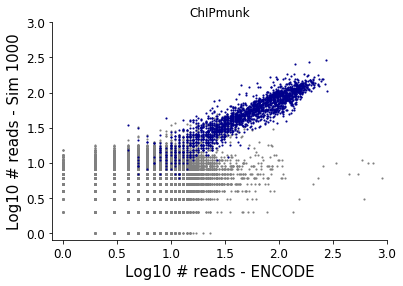

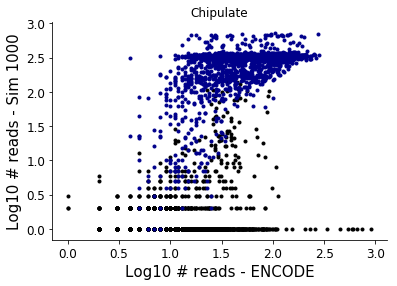

In [15]:
chipulate_nc = 1000000

# Load bin data - chipulate
sim_bins2 = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.chipulate.cov.%skb.bed"%(chipulate_nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
bindata2 = pd.DataFrame({"pos": enc_bins["pos"], "end":enc_bins["end"], \
                        "enc.counts": enc_bins["enc.counts"], \
                        "sim.counts": sim_bins2["sim.counts"]})
bindata2 = bindata2[bindata2["enc.counts"]+bindata2["sim.counts"]>0]
bindata2 = pd.merge(bindata2, binannot, on=["pos","end"])

fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ax.scatter(np.log10(bindata2[~bindata2["overlap"]]["enc.counts"]+pc),
          np.log10(bindata2[~bindata2["overlap"]]["sim.counts"]+pc),
          color="black", alpha=alpha, marker=".")
ax.scatter(np.log10(bindata2[bindata2["overlap"]]["enc.counts"]+pc),
          np.log10(bindata2[bindata2["overlap"]]["sim.counts"]+pc),
          color="darkblue", alpha=alpha,  marker=".")
#ax.set_xlim(left=0.5, right=3.0)
#ax.set_ylim(bottom=0.5, top=3.0)
ax.set_xlabel("Log10 # reads - ENCODE", size=15)
ax.set_ylabel("Log10 # reads - Sim %s"%nc, size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
ax.set_title("Chipulate")
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_scatter_%s_chipulate.pdf"%factor))



# Print corr
for b in [bindata, bindata2]:
    peakbins_corr = (scipy.stats.pearsonr(np.log10(b[b["overlap"]]["enc.counts"]+pc), np.log10(b[b["overlap"]]["sim.counts"]+pc)))
    nopeakbins_corr = (scipy.stats.pearsonr(np.log10(b[~b["overlap"]]["enc.counts"]+pc), np.log10(b[~b["overlap"]]["sim.counts"]+pc)))
    all_corr = (scipy.stats.pearsonr(np.log10(b["enc.counts"]+pc), np.log10(b["sim.counts"]+pc)))

    print("Overlap: %s"%str(peakbins_corr))
    print("No overlap: %s"%str(nopeakbins_corr))
    print("All: %s"%str(all_corr))

/home/mgymrek/.local/lib/python3.4/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


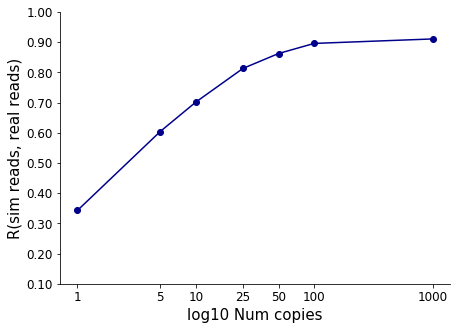

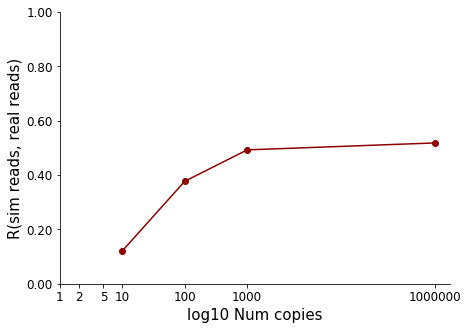

In [17]:
#### get corr for different cell nums
enc_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".ENCODE.cov.%skb.bed"%binsize), usecols=[1,2,3], names=["pos","end","enc.counts"], sep="\t")

ncs = [1, 5, 10, 25, 50, 100, 1000]
chipulate_ncs = [1, 2, 5, 10, 100, 1000, 1000000]
rvals_peak = []
rvals_peak_chipulate = []
for nc in ncs:
    sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
    bindata = pd.DataFrame({"pos": enc_bins["pos"], "end": enc_bins["end"], 
                            "enc.counts": enc_bins["enc.counts"], "sim.counts": sim_bins["sim.counts"]})
    bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
    bindata = pd.merge(bindata, binannot, on=["pos","end"])

    # separate by overlap/no overlap peaks  
    r_peak = scipy.stats.pearsonr(np.log10((bindata[bindata["overlap"]]["enc.counts"])+pc), np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc))[0]
    rvals_peak.append(r_peak)

fig = plt.figure()
fig.set_size_inches((7, 5))
ax = fig.add_subplot(111)
ax.plot(np.log10(ncs), rvals_peak, marker="o", color="darkblue");
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("R(sim reads, real reads)", size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
if "H3K27ac" in factor:
    ax.set_ylim(bottom=0.8, top=1.0)
else:
    ax.set_ylim(bottom=0.1, top=1.0)
ax.set_xticks(np.log10(ncs))
ax.set_xticklabels(ncs, size=12)
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_%s.pdf"%factor))


for nc in chipulate_ncs:
    sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.chipulate.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
    bindata = pd.DataFrame({"pos": enc_bins["pos"], "end": enc_bins["end"], 
                            "enc.counts": enc_bins["enc.counts"], "sim.counts": sim_bins["sim.counts"]})
    bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
    bindata = pd.merge(bindata, binannot, on=["pos","end"])

    # separate by overlap/no overlap peaks  
    r_peak = scipy.stats.pearsonr(np.log10((bindata[bindata["overlap"]]["enc.counts"])+pc), np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc))[0]
    rvals_peak_chipulate.append(r_peak)
    
fig = plt.figure()
fig.set_size_inches((7, 5))
ax = fig.add_subplot(111)
ax.plot(np.log10(chipulate_ncs), rvals_peak_chipulate, marker="o", color="darkred");
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("R(sim reads, real reads)", size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylim(bottom=0.0, top=1.0)
ax.set_xticks(np.log10(chipulate_ncs))
ax.set_xticklabels(chipulate_ncs, size=12)
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_%s_chipulate.pdf"%factor))


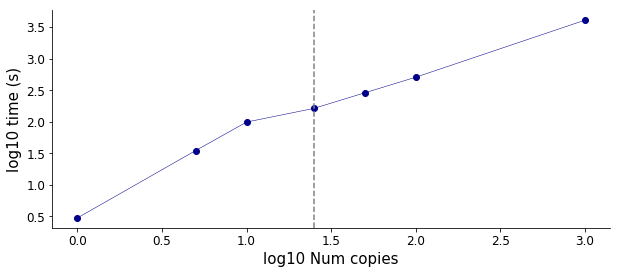

In [5]:
# Time vs. num copies
ncs = [1, 5, 10, 25, 50, 100, 1000] 
#timing = [3, 28, 60+10, 2*60+15, 4*60+32, 7*60+58, 69*60+28]
timing = [3, 35, 60+39, 2*60+43, 4*60+48,8*60+28, 67*60+46]
#chipulate_ncs = [1, 2, 5, 10, 100, 1000]
#chipulate_timing = [item*60 for item in [79,73,73,78,83,88] ]
fig = plt.figure()
fig.set_size_inches((10, 4))
ax = fig.add_subplot(111)
ax.plot(np.log10(ncs), np.log10(timing), marker="o", linewidth=0.5, color="darkblue")
#ax.plot(np.log10(chipulate_ncs), np.log10(chipulate_timing), marker="o", linewidth=0.5, color="red")
ax.axvline(x=np.log10(25), linestyle="dashed", color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("log10 time (s)", size=15)
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_timing_%s.pdf"%factor))